# Detector de imagenes (Fumadores)

"Remember Us" presenta un innovador sistema de clasificación de imágenes basado en inteligencia artificial para detectar en tiempo real si una persona está fumando en áreas donde está prohibido, como gasolineras, fábricas con materiales inflamables o espacios públicos sensibles.

**Objetivo:**
Reducir el riesgo de incendios y accidentes en zonas de alto peligro mediante la implementación de inteligencia artificial para la detección automática de personas fumando en lugares prohibidos.

**¿Porque es importante?**

Según la NFPA, los incendios en gasolineras causan millones de dólares en pérdidas y ponen vidas en peligro. Los cigarrillos representan una de las principales causas de incendios en industrias.Con una solución automatizada, podemos prevenir tragedias antes de que ocurran.

**Modelos utilizados:**

|      Modelo                     | Precisión   |
|---------------------------------|-------------|
| YoloV8s                         | 90%         |
| Xception                        | 82%         |
| SVC - Sklearn                   | 77%         |



## Precisión de los modelos

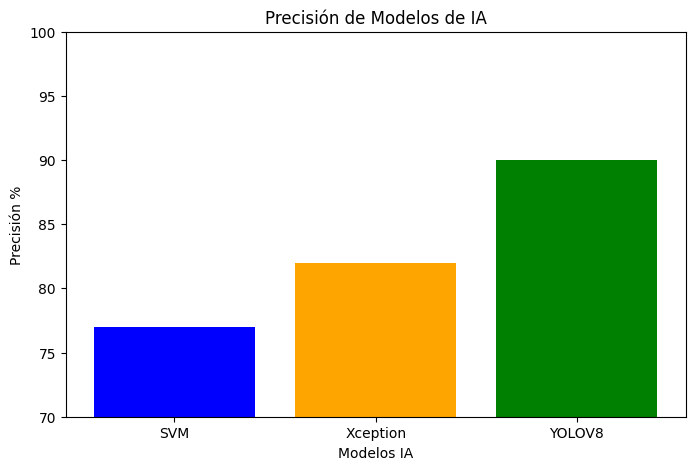

In [1]:
import matplotlib.pyplot as plt
import numpy as np

modelos = ["SVM", "Xception", "YOLOV8"]
precision = np.array([77, 82, 90])

plt.figure(figsize=(8,5))
plt.bar(modelos, precision, color=['blue', 'orange', 'green'])

plt.xlabel("Modelos IA")
plt.ylabel("Precisión %")
plt.title("Precisión de Modelos de IA")
plt.ylim(70, 100)


plt.show()


## Entrenamiento de modelos

### SVC - Sklearn

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from PIL import Image
import numpy as np
import os

#### Tratamiento de datos

In [ ]:
# Función para cargar las imagenes desde el folder y almacenarlas en forma de vector númerico, junto con otro array con su clasificación
def svc_loadImages(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert("L")
        img = img.resize((250,250))
        img_array = np.array(img).flatten()
        images.append(img_array)
        label = 0 if "notsmoking" in filename else 1 # Si el nombre de la imagen es 'notsmoking' colocar 0, caso contrario 1
        labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
#Separacion imagenes train y test
scv_Xtrain, svc_ytrain = svc_loadImages("recursos/dataset/Training")
svc_Xval, svc_yval = svc_loadImages("recursos/dataset/Validation")
svc_Xtest, svc_ytest = svc_loadImages("recursos/dataset/Testing")

print(f"Datos de entrenamiento: {len(scv_Xtrain)}\tPorcentaje: {(len(scv_Xtrain)*100/1120):.2f}")
print(f"Datos de validación: {len(svc_Xval)}\tPorcentaje: {(len(svc_Xval)*100/1120):.2f}")
print(f"Datos de prueba: {len(svc_Xtest)}\t\tPorcentaje: {(len(svc_Xtest)*100/1120):.2f}")


#Escalado de imagenes con StandarScaler
scaler = StandardScaler()

scv_Xtrain_st = scaler.fit_transform(scv_Xtrain)
scv_Xval_st = scaler.transform(svc_Xval)
scv_Xtest_st = scaler.transform(svc_Xtest)

scv_Xtrain[:2], scv_Xtrain_st[:2]


#Reducir dimensionalidad con PCA a 90 componentes (componentes originales = 250)
pca = PCA(n_components=90)

scv_Xtrain_pca = pca.fit_transform(scv_Xtrain_st)
scv_Xval_pca = pca.transform(scv_Xval_st)
scv_Xtest_pca = pca.transform(scv_Xtest_st)

Datos de entrenamiento: 716	Porcentaje: 63.93
Datos de validación: 180	Porcentaje: 16.07
Datos de prueba: 224		Porcentaje: 20.00


#### Entrenamiento del modelo svc

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import numpy as np

svm = SVC(kernel="linear", random_state=42)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_score = -np.inf
best_model = None

# Realizar validación cruzada
for train_idx, val_idx in cv.split(scv_Xtrain_pca, svc_ytrain):
    X_train_fold, X_val_fold = scv_Xtrain_pca[train_idx], scv_Xtrain_pca[val_idx]
    y_train_fold, y_val_fold = svc_ytrain[train_idx], svc_ytrain[val_idx]


    svm.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo
    score = svm.score(X_val_fold, y_val_fold)

    if score > best_score:
        best_score = score
        best_model = SVC(kernel="linear", random_state=42)
        best_model.fit(scv_Xtrain_pca, svc_ytrain)

# Porcenaje final
print(f"Puntuación del mejor modelo: {best_score:.2f}")

precision del 0.77

### MobileNetV2 (CNN) (keras)

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Pre-procesamiento de la data

In [ ]:
ruta_origen = "dataset/dataset/Training"
ruta_smoking = "dataset/dataset/training/smoking"
ruta_notsmoking = "dataset/dataset/training/notsmoking"

os.makedirs(ruta_smoking, exist_ok=True)
os.makedirs(ruta_notsmoking, exist_ok=True)

for archivo in os.listdir(ruta_origen):
  if os.path.isfile(os.path.join(ruta_origen, archivo)):
    if "notsmoking" not in archivo.lower() :
            shutil.move(os.path.join(ruta_origen, archivo), os.path.join(ruta_smoking, archivo))
    elif(True):
            shutil.move(os.path.join(ruta_origen, archivo), os.path.join(ruta_notsmoking, archivo))


datadir = "/content/dataset/dataset/training"
imgsize = (224, 224)
batchsize = (32)

datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.2)

train_data = datagen.flow_from_directory(datadir,target_size=imgsize,
                                         batch_size=batchsize,class_mode='binary',subset='training')
val_data = datagen.flow_from_directory(datadir,target_size=imgsize,
                                       batch_size=batchsize,class_mode='binary',subset='validation')

Found 574 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


Instanciación del modelo (preentrenado)

In [ ]:
from tensorflow.keras import layers, regularizers

# Modelo base Xception
mnet = keras.applications.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
mnet.trainable = True
for layer in mnet.layers[:-5]:
    layer.trainable = False

model = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),

    mnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.Dropout(0.8),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    )
]

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    callbacks=callbacks
)

# Mostrar el porcentaje de precisión final en validación
final_accuracy = history.history['val_accuracy'][-1] * 100
print(f"Precisión final en validación: {final_accuracy:.2f}%")

# Guardar el modelo entrenado
model.save("modelo_xception.h5")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.4607 - loss: 1.3647 - val_accuracy: 0.6268 - val_loss: 0.7300
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.5265 - loss: 1.2696 - val_accuracy: 0.6620 - val_loss: 0.7117
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.6285 - loss: 0.9654 - val_accuracy: 0.7042 - val_loss: 0.6884
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5711 - loss: 1.1540 - val_accuracy: 0.7042 - val_loss: 0.6728
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.6053 - loss: 1.0211 - val_accuracy: 0.7324 - val_loss: 0.6569
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6917 - loss: 0.8197 - val_accuracy: 0.7324 - val_loss: 0.6460
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.6643 - loss: 0.8676 - val_accuracy: 0.7183 - val_loss: 0.6278
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6447 - loss: 0.8166 - val_accuracy: 0.7535 - va

## Yolo

In [ ]:
from ultralytics import YOLO

# Cargar un modelo preentrenado (base)
model = YOLO("yolov8s.pt")  # Puedes elegir entre diferentes tamaños: 'n', 's', 'm', 'l', 'x'

# Entrenar el modelo con tu conjunto de datos
model.train(
    data="recursos/smokersYolo8/data.yaml",  # Archivo YAML con la configuración del dataset
    epochs=100,                      # Número de épocas
    batch=16,                       # Tamaño del lote
    imgsz=250,                      # Tamaño de la imagen
    device="cuda"                    # Usa "cuda" si tienes GPU
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 68.6MB/s]


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/smokersYolo/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=250, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.1MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[250] must be multiple of max stride 32, updating to [256]


train: Scanning /content/dataset/smokersYolo/train/labels... 476 images, 0 backgrounds, 0 corrupt: 100%|██████████| 476/476 [00:00<00:00, 1654.32it/s]

train: New cache created: /content/dataset/smokersYolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/smokersYolo/valid/labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 394.66it/s]

val: New cache created: /content/dataset/smokersYolo/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.293G      1.861      2.328      1.797          6        256: 100%|██████████| 60/60 [00:08<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all         60         60      0.417       0.55      0.449      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.311G      1.703      1.893      1.707          5        256: 100%|██████████| 60/60 [00:05<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.95it/s]

                   all         60         60      0.535      0.567      0.501      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.328G      1.744      1.882      1.743         12        256: 100%|██████████| 60/60 [00:06<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]

                   all         60         60      0.507      0.618      0.524      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.344G      1.705      1.826      1.697          6        256: 100%|██████████| 60/60 [00:05<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

                   all         60         60       0.48      0.583      0.517      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.361G       1.69      1.737       1.67          6        256: 100%|██████████| 60/60 [00:06<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all         60         60      0.638      0.646      0.677      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.379G      1.672      1.798      1.665          5        256: 100%|██████████| 60/60 [00:05<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

                   all         60         60      0.582      0.604      0.609      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.395G      1.673      1.704      1.646          7        256: 100%|██████████| 60/60 [00:06<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]

                   all         60         60      0.514       0.67      0.577      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.412G       1.63      1.714      1.644          7        256: 100%|██████████| 60/60 [00:06<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all         60         60      0.406      0.683      0.529      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      0.43G      1.613       1.68      1.633          6        256: 100%|██████████| 60/60 [00:06<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all         60         60      0.618      0.617      0.668      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.447G       1.58      1.597      1.587          9        256: 100%|██████████| 60/60 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.40it/s]

                   all         60         60      0.537       0.75      0.604      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.463G      1.577      1.553      1.594         10        256: 100%|██████████| 60/60 [00:05<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.49it/s]

                   all         60         60      0.726      0.617      0.752      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.48G      1.544      1.566      1.587          6        256: 100%|██████████| 60/60 [00:05<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

                   all         60         60      0.638       0.75      0.679      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.498G      1.579       1.52      1.604          7        256: 100%|██████████| 60/60 [00:05<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.85it/s]

                   all         60         60      0.752      0.708      0.768      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.514G       1.57      1.554      1.587          8        256: 100%|██████████| 60/60 [00:05<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.19it/s]

                   all         60         60       0.56      0.717      0.559      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.531G      1.535      1.535      1.568          8        256: 100%|██████████| 60/60 [00:05<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.06it/s]

                   all         60         60      0.656      0.683      0.726      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.549G      1.482      1.491      1.547          9        256: 100%|██████████| 60/60 [00:05<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

                   all         60         60      0.618      0.728      0.761      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.566G      1.495      1.496      1.544         12        256: 100%|██████████| 60/60 [00:05<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

                   all         60         60      0.758      0.783       0.79      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.582G      1.487      1.462      1.516         15        256: 100%|██████████| 60/60 [00:05<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

                   all         60         60      0.678      0.683      0.664      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       0.6G      1.532      1.402      1.547         11        256: 100%|██████████| 60/60 [00:05<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]

                   all         60         60      0.779      0.706      0.828      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.617G      1.452      1.349      1.506         10        256: 100%|██████████| 60/60 [00:05<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

                   all         60         60      0.598      0.767      0.709      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.633G      1.446      1.375      1.521          8        256: 100%|██████████| 60/60 [00:05<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]

                   all         60         60      0.709      0.772      0.817      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      0.65G      1.476      1.321      1.523          6        256: 100%|██████████| 60/60 [00:05<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all         60         60      0.721      0.783      0.826      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.668G      1.426      1.329      1.486         10        256: 100%|██████████| 60/60 [00:05<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.44it/s]

                   all         60         60      0.543      0.752      0.709      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.686G      1.385      1.322      1.458         10        256: 100%|██████████| 60/60 [00:06<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.00it/s]

                   all         60         60      0.705      0.733      0.767      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.701G      1.412      1.266      1.474          9        256: 100%|██████████| 60/60 [00:05<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]

                   all         60         60      0.734        0.8      0.808      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.719G      1.426      1.274      1.486         13        256: 100%|██████████| 60/60 [00:06<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

                   all         60         60      0.779      0.764      0.831      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.736G      1.389      1.272      1.471         10        256: 100%|██████████| 60/60 [00:05<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.61it/s]

                   all         60         60      0.717      0.817      0.824      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.754G      1.402      1.236      1.484          6        256: 100%|██████████| 60/60 [00:06<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.94it/s]

                   all         60         60      0.705       0.75       0.79      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      0.77G      1.367      1.217      1.441          8        256: 100%|██████████| 60/60 [00:05<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.82it/s]

                   all         60         60      0.801      0.871      0.873      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.787G      1.364      1.195      1.447          8        256: 100%|██████████| 60/60 [00:06<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.31it/s]

                   all         60         60      0.749      0.833      0.865      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.805G      1.317      1.193       1.43         11        256: 100%|██████████| 60/60 [00:05<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]

                   all         60         60      0.667      0.717      0.716       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.822G      1.289      1.138      1.408          9        256: 100%|██████████| 60/60 [00:06<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.03it/s]

                   all         60         60      0.827       0.85       0.91       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.838G      1.291      1.113      1.407         11        256: 100%|██████████| 60/60 [00:05<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]

                   all         60         60      0.779        0.8      0.826      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.855G      1.283      1.084      1.411          7        256: 100%|██████████| 60/60 [00:06<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.74it/s]

                   all         60         60      0.733      0.733      0.822      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.873G      1.261      1.081      1.387          9        256: 100%|██████████| 60/60 [00:05<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.75it/s]

                   all         60         60      0.784      0.683      0.808      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.889G      1.227      1.072      1.379          7        256: 100%|██████████| 60/60 [00:06<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]

                   all         60         60      0.749      0.767       0.81      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.906G      1.231      1.044      1.391         16        256: 100%|██████████| 60/60 [00:05<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.05it/s]

                   all         60         60      0.835      0.845      0.887       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.924G      1.211      1.008      1.354         10        256: 100%|██████████| 60/60 [00:06<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]

                   all         60         60      0.822        0.8      0.876      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.939G      1.246       1.05      1.386          5        256: 100%|██████████| 60/60 [00:05<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

                   all         60         60      0.748       0.84      0.828      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.957G      1.217      1.018      1.359         11        256: 100%|██████████| 60/60 [00:06<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.96it/s]

                   all         60         60      0.751      0.767       0.83      0.329


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.975G      1.184     0.9699      1.371          4        256: 100%|██████████| 60/60 [00:05<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.15it/s]

                   all         60         60       0.92       0.65      0.831      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.992G      1.064     0.7964      1.277          4        256: 100%|██████████| 60/60 [00:06<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]

                   all         60         60      0.826       0.75      0.867      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.01G      1.009     0.7322      1.232          4        256: 100%|██████████| 60/60 [00:05<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.42it/s]

                   all         60         60      0.957      0.745      0.906       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.03G     0.9894     0.6952      1.208          4        256: 100%|██████████| 60/60 [00:06<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]

                   all         60         60      0.789        0.8      0.886      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.04G     0.9801     0.6641      1.208          4        256: 100%|██████████| 60/60 [00:05<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.78it/s]

                   all         60         60      0.867      0.783       0.87      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.06G     0.9494     0.6687      1.204          4        256: 100%|██████████| 60/60 [00:06<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

                   all         60         60      0.906       0.75      0.858      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.08G     0.9201     0.6568      1.186          4        256: 100%|██████████| 60/60 [00:05<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.48it/s]

                   all         60         60      0.905      0.767      0.905      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.09G     0.8716     0.6133      1.138          4        256: 100%|██████████| 60/60 [00:06<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]

                   all         60         60      0.903      0.767      0.893      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.11G     0.8842     0.6163      1.147          4        256: 100%|██████████| 60/60 [00:05<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]

                   all         60         60      0.925       0.75       0.89      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.13G     0.8461     0.5915      1.144          4        256: 100%|██████████| 60/60 [00:06<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

                   all         60         60      0.915      0.767      0.888      0.348



50 epochs completed in 0.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


                   all         60         60      0.835      0.846      0.887       0.39
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.30GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 256, 256) BCHW and output shape(s) (1, 5, 1344) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 191.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 220.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 170.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'/content/runs/detect/train/weights/best.onnx'

## **Conclusión:** 



La implementación de inteligencia artificial para la detección de personas fumando en áreas restringidas representa una solución innovadora y efectiva para mejorar la seguridad y el cumplimiento de normativas. Al automatizar la identificación de estas infracciones en tiempo real, se reduce la necesidad de monitoreo manual, se agiliza la respuesta ante riesgos y se previenen incidentes que podrían poner en peligro la salud y el bienestar de la comunidad.

Este sistema no solo contribuye a la protección de espacios libres de humo, sino que también refuerza la concienciación sobre la importancia de respetar las regulaciones establecidas. Además, su capacidad de integración con sistemas de vigilancia y seguridad existentes lo convierte en una herramienta versátil y escalable.
